In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import tensorflow as tf
import pyedflib

sys.path.append('..')

from sleeprnn.helpers import reader
from sleeprnn.data import utils
from sleeprnn.common import constants, pkeys, viz

viz.notebook_full_width()
%matplotlib inline

## EEG reading

In [39]:
ISRUC_DATA_PATH = "/home/ntapia/projects/sleep-rnn/resources/datasets/unlabeled_isruc"
REC_PATH = os.path.join(ISRUC_DATA_PATH, "register")
STATE_PATH = os.path.join(ISRUC_DATA_PATH, "label/state")
# Por ahora se ignorará el '1-025'
invalid_subjects = ["1-025"]

In [41]:
subject_ids = [s[:5] for s in os.listdir(REC_PATH) if ".rec" in s]
subject_ids = [s for s in subject_ids if s not in invalid_subjects]
subject_ids.sort()
print(subject_ids)

['1-003', '1-004', '1-006', '1-018', '1-027', '1-029', '1-031', '1-033', '1-036', '1-038', '1-046', '1-048', '1-050', '1-052', '1-053', '1-057', '1-058', '1-062', '1-065', '1-067', '1-069', '1-072', '1-076', '1-079', '1-087', '1-090', '1-092', '1-093', '1-098', '1-099', '3-001', '3-002', '3-006', '3-007', '3-008', '3-009', '3-010']


In [42]:
fs = 200
pctl_to_std = 98
clip_value = 10
signal_dict = {}
for subject_id in subject_ids:
    print("")
    path_eeg_file = os.path.join(REC_PATH, "%s PSG.rec" % subject_id)

    channels_to_try = [
        ("C3-A2",),
        ("C3-M2",),
        ("C3", "A2"),
        ("C3", "M2"),
    ]
    with pyedflib.EdfReader(path_eeg_file) as file:
        channel_names = file.getSignalLabels()
        while len(channels_to_try) > 0:
            channel = channels_to_try.pop(0)
            if np.all([chn in channel_names for chn in channel]):
                break
        chn = channel_names.index(channel[0])
        signal = file.readSignal(chn)
        fs_old = file.samplefrequency(chn)
        if len(channel) == 2:
            chn2 = channel_names.index(channel[1])
            signal2 = file.readSignal(chn2)
            signal = signal - signal2
            # Check
            print('Subject %s | Channel extracted: %s minus %s at %s Hz' % (subject_id, file.getLabel(chn), file.getLabel(chn2), fs_old))
        else:
            # Check
            print('Subject %s | Channel extracted: %s at %s Hz' % (subject_id, file.getLabel(chn), fs_old))
    # fs for ISRUC will be considered 200 Hz since it is a difference only at the 15th decimal.
    fs_old_round = int(np.round(fs_old))  
    # Broand bandpass filter to signal
    signal = utils.broad_filter(signal, fs_old_round)
    # Now resample to the required frequency
    if fs != fs_old_round:
        print('Resampling from %d Hz to required %d Hz' % (fs_old_round, fs))
        signal = utils.resample_signal(signal, fs_old=fs_old_round, fs_new=fs)
    else:
        print('Signal already at required %d Hz' % fs)
    signal = signal.astype(np.float32)
    # Robust normalization
    outlier_thr = np.percentile(np.abs(signal), pctl_to_std)
    tmp_signal = signal[np.abs(signal) <= outlier_thr]
    std_to_normalize = tmp_signal.std()
    signal = signal / std_to_normalize
    signal = np.clip(signal, -clip_value, clip_value)
    signal_dict[subject_id] = signal


Subject 1-003 | Channel extracted: C3-A2 at 200.00000000000003 Hz
Signal already at required 200 Hz

Subject 1-004 | Channel extracted: C3-A2 at 200.00000000000003 Hz
Signal already at required 200 Hz

Subject 1-006 | Channel extracted: C3-A2 at 200.00000000000003 Hz
Signal already at required 200 Hz

Subject 1-018 | Channel extracted: C3-A2 at 200.00000000000003 Hz
Signal already at required 200 Hz

Subject 1-027 | Channel extracted: C3-M2 at 200.00000000000003 Hz
Signal already at required 200 Hz

Subject 1-029 | Channel extracted: C3-M2 at 200.00000000000003 Hz
Signal already at required 200 Hz

Subject 1-031 | Channel extracted: C3-M2 at 200.00000000000003 Hz
Signal already at required 200 Hz

Subject 1-033 | Channel extracted: C3-M2 at 200.00000000000003 Hz
Signal already at required 200 Hz

Subject 1-036 | Channel extracted: C3-M2 at 200.00000000000003 Hz
Signal already at required 200 Hz

Subject 1-038 | Channel extracted: C3-M2 at 200.00000000000003 Hz
Signal already at requir

## Hypnogram reading

In [82]:
n2_id = 2
original_page_duration = 30
page_duration = 20
page_size = int(fs * page_duration)

n2_pages_dict = {}
for subject_id in subject_ids:
    print("")
    signal_length = signal_dict[subject_id].size
    print(signal_length)
    path_states_file = os.path.join(STATE_PATH, "%s Base E1.txt" % subject_id)
    states = np.loadtxt(path_states_file, dtype='i', delimiter=' ')
    # These are pages with 30s durations. To work with 20s pages
    # We consider the intersections with 20s divisions
    n2_pages_original = np.where(states == n2_id)[0]
    print('Original N2 pages: %d' % n2_pages_original.size)
    onsets_original = n2_pages_original * original_page_duration
    offsets_original = (n2_pages_original + 1) * original_page_duration
    total_pages = int(np.ceil(signal_length / page_size))
    n2_pages_onehot = np.zeros(total_pages, dtype=np.int16)
    for i in range(total_pages):
        onset_new_page = i * page_duration
        offset_new_page = (i + 1) * page_duration
        for j in range(n2_pages_original.size):
            intersection = (onset_new_page < offsets_original[j]) and (onsets_original[j] < offset_new_page)
            if intersection:
                n2_pages_onehot[i] = 1
                break
    n2_pages = np.where(n2_pages_onehot == 1)[0]
    # Drop first, last and second to last page of the whole registers
    # if they where selected.
    last_page = total_pages - 1
    n2_pages = n2_pages[
        (n2_pages != 0)
        & (n2_pages != last_page)
        & (n2_pages != last_page - 1)]
    n2_pages = n2_pages.astype(np.int16)
    print("Subject %s - Total N2 pages %d" % (subject_id, n2_pages.size))
    n2_pages_dict[subject_id] = n2_pages


5658000
Original N2 pages: 370
Subject 1-003 - Total N2 pages 577

5778000
Original N2 pages: 420
Subject 1-004 - Total N2 pages 650

5382000
Original N2 pages: 47
Subject 1-006 - Total N2 pages 74

5994000
Original N2 pages: 489
Subject 1-018 - Total N2 pages 745

5508000
Original N2 pages: 297
Subject 1-027 - Total N2 pages 455

5472000
Original N2 pages: 302
Subject 1-029 - Total N2 pages 483

5262000
Original N2 pages: 475
Subject 1-031 - Total N2 pages 732

5520000
Original N2 pages: 232
Subject 1-033 - Total N2 pages 370

5922000
Original N2 pages: 219
Subject 1-036 - Total N2 pages 356

5592000
Original N2 pages: 297
Subject 1-038 - Total N2 pages 489

5178000
Original N2 pages: 432
Subject 1-046 - Total N2 pages 668

5886000
Original N2 pages: 254
Subject 1-048 - Total N2 pages 389

5430000
Original N2 pages: 415
Subject 1-050 - Total N2 pages 632

5472000
Original N2 pages: 370
Subject 1-052 - Total N2 pages 579

5460000
Original N2 pages: 382
Subject 1-053 - Total N2 pages 5

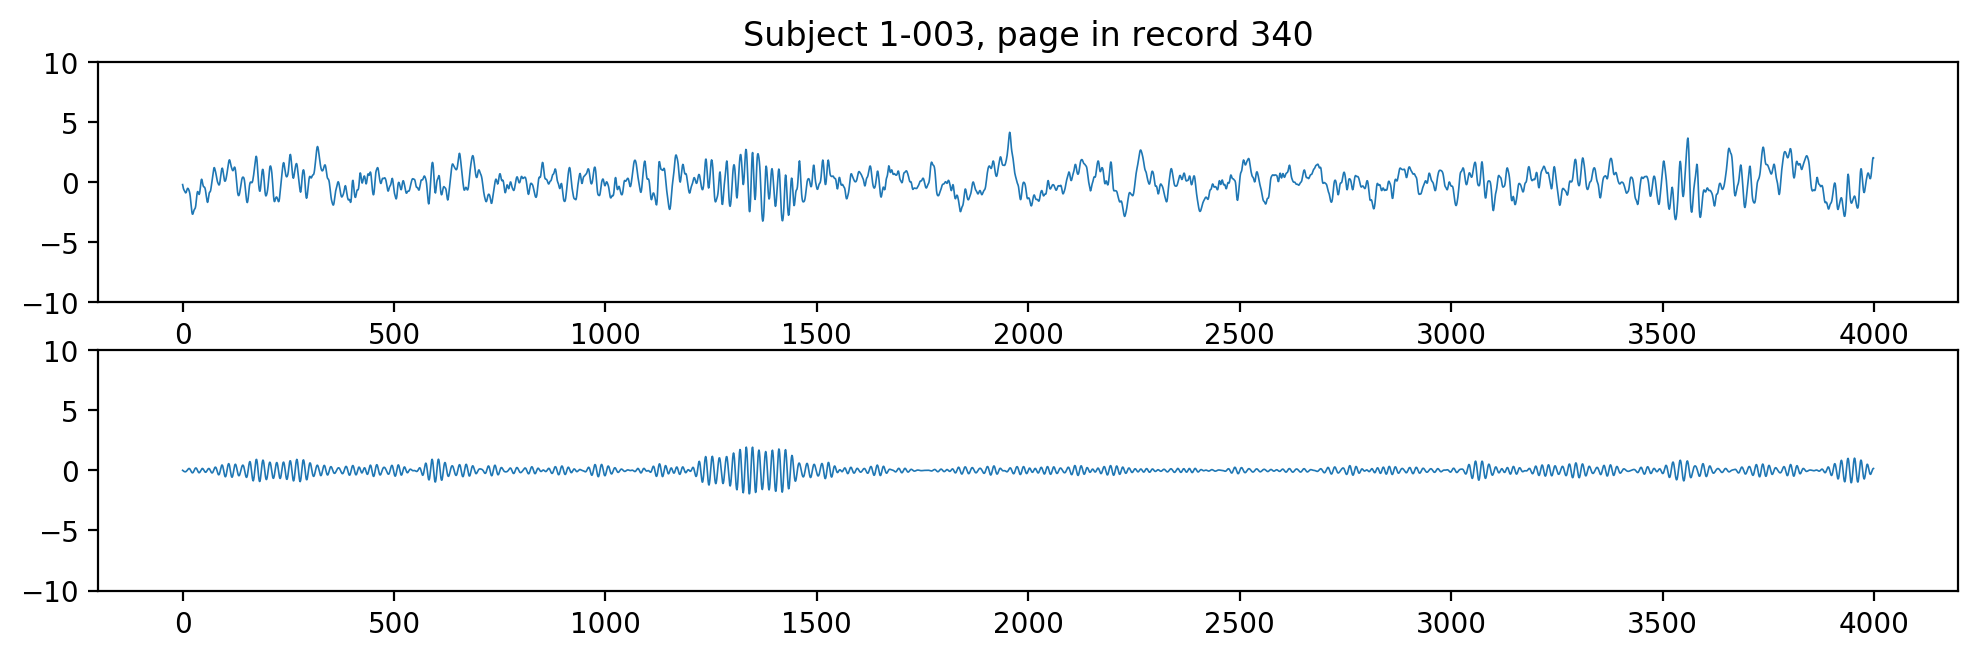

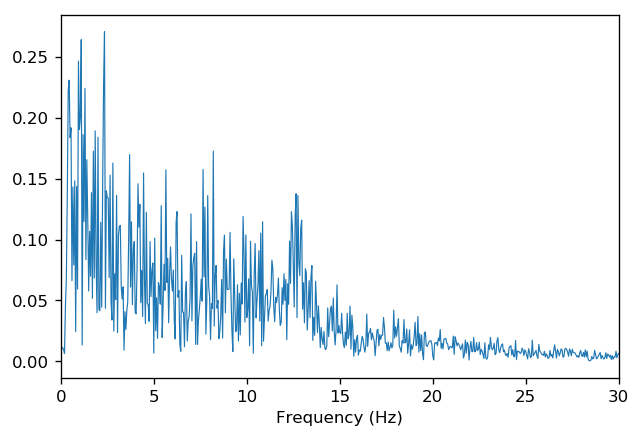

In [74]:
page_index_to_show = 110
subject_id = "1-003"

page = n2_pages_dict[subject_id][page_index_to_show]
start_sample = int(page * page_size)
end_sample = start_sample + page_size
segment_signal = signal_dict[subject_id][start_sample:end_sample]
fig, axes = plt.subplots(2, 1, figsize=(12, 3.5), dpi=200)
axes[0].plot(segment_signal, linewidth=0.6)
axes[0].set_ylim([-10, 10])
sigma_signal = utils.broad_filter(segment_signal, fs, lowcut=11, highcut=16)
axes[1].plot(sigma_signal, linewidth=0.6)
axes[1].set_ylim([-10, 10])
axes[0].set_title("Subject %s, page in record %d" % (subject_id, page))
plt.show()

power, freq = utils.power_spectrum(segment_signal, fs)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=120)
ax.plot(freq, power, linewidth=0.7)
ax.set_xlim([0, 30])
ax.set_xlabel("Frequency (Hz)")
plt.show()

# Mean spectrum

In [79]:
mean_power_dict = {}
for subject_id in signal_dict.keys():
    all_pages_power = []
    for page in n2_pages_dict[subject_id]:
        start_sample = int(page * page_size)
        end_sample = start_sample + page_size
        segment_signal = signal_dict[subject_id][start_sample:end_sample]
        power, freq = utils.power_spectrum(segment_signal, fs)
        all_pages_power.append(power)
    mean_power_dict[subject_id] = np.stack(all_pages_power, axis=0).mean(axis=0)

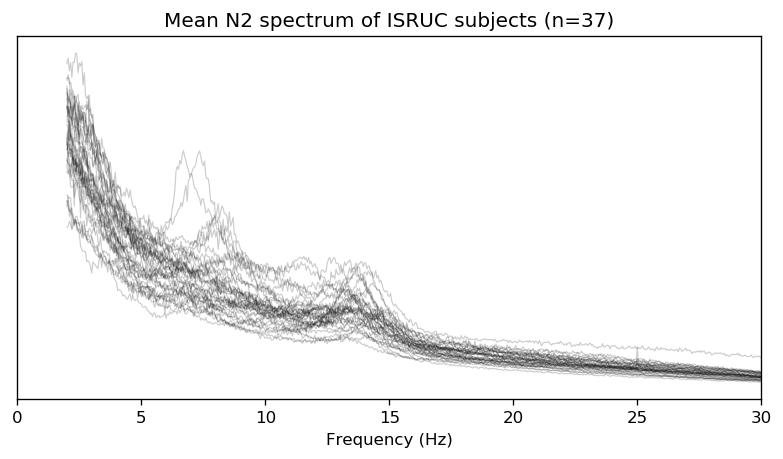

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=120)
min_freq = 2
max_freq = 30
plot_indices = np.where((freq >= min_freq) & (freq <= max_freq))[0]
for subject_id in mean_power_dict.keys():
    ax.plot(freq[plot_indices], mean_power_dict[subject_id][plot_indices], linewidth=0.7, color="k", alpha=0.2)
    ax.set_xlim([0, 30])
    ax.set_yticks([])
ax.set_title("Mean N2 spectrum of ISRUC subjects (n=%d)" % len(mean_power_dict.keys()))
ax.set_xlabel("Frequency (Hz)")
plt.show()

# Comparison of spectrum with MASS

In [50]:
mass = reader.load_dataset(constants.MASS_SS_NAME)

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
Mean FFT Scaling of non-testing set: 1.5594099147386842
Per subject FFT scaling / Mean:
S01: 1.0215
S02: 1.0696
S03: 1.0474
S05: 1.0631
S06: 0.9940
S07: 0.9877
S09: 0.9348
S10: 0.8341
S11: 1.0459
S12: 0.7592
S13: 1.0895
S14: 0.9727
S17: 0.9233
S18: 0.9265
S19: 1.2431
Using Custom Scaling Dict
S01: 1.0000
S02: 1.0000
S03: 1.0000
S05: 1.0000
S06: 1.0000
S07: 1.0000
S09: 1.0000
S10: 1.0000
S11: 1.0000
S12: 1.0000
S13: 1.0000
S14: 1.0000
S17: 1.0000
S18: 1.0000
S19: 1.0000


In [56]:
mass_mean_power_dict = {}
for subject_id in mass.train_ids:
    all_pages_power = []
    n2_pages_of_subject = mass.get_subject_pages(subject_id, pages_subset=constants.N2_RECORD)
    signal_of_subject = mass.get_subject_signal(subject_id, normalize_clip=True)
    for page in n2_pages_of_subject:
        start_sample = int(page * page_size)
        end_sample = start_sample + page_size
        segment_signal = signal_of_subject[start_sample:end_sample]
        power, freq = utils.power_spectrum(segment_signal, fs)
        all_pages_power.append(power)
    mass_mean_power_dict[subject_id] = np.stack(all_pages_power, axis=0).mean(axis=0)

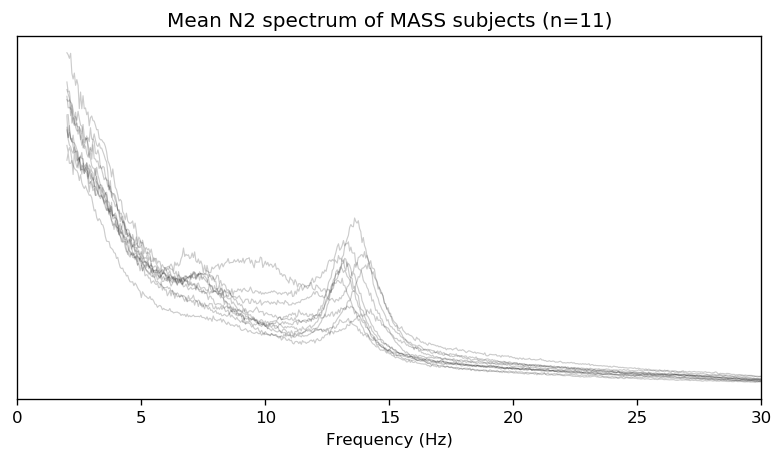

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=120)
min_freq = 2
max_freq = 30
plot_indices = np.where((freq >= min_freq) & (freq <= max_freq))[0]
for subject_id in mass_mean_power_dict.keys():
    ax.plot(freq[plot_indices], mass_mean_power_dict[subject_id][plot_indices], linewidth=0.7, color="k", alpha=0.2)
    ax.set_xlim([0, 30])
    ax.set_yticks([])
ax.set_title("Mean N2 spectrum of MASS subjects (n=%d)" % len(mass_mean_power_dict.keys()))
ax.set_xlabel("Frequency (Hz)")
plt.show()

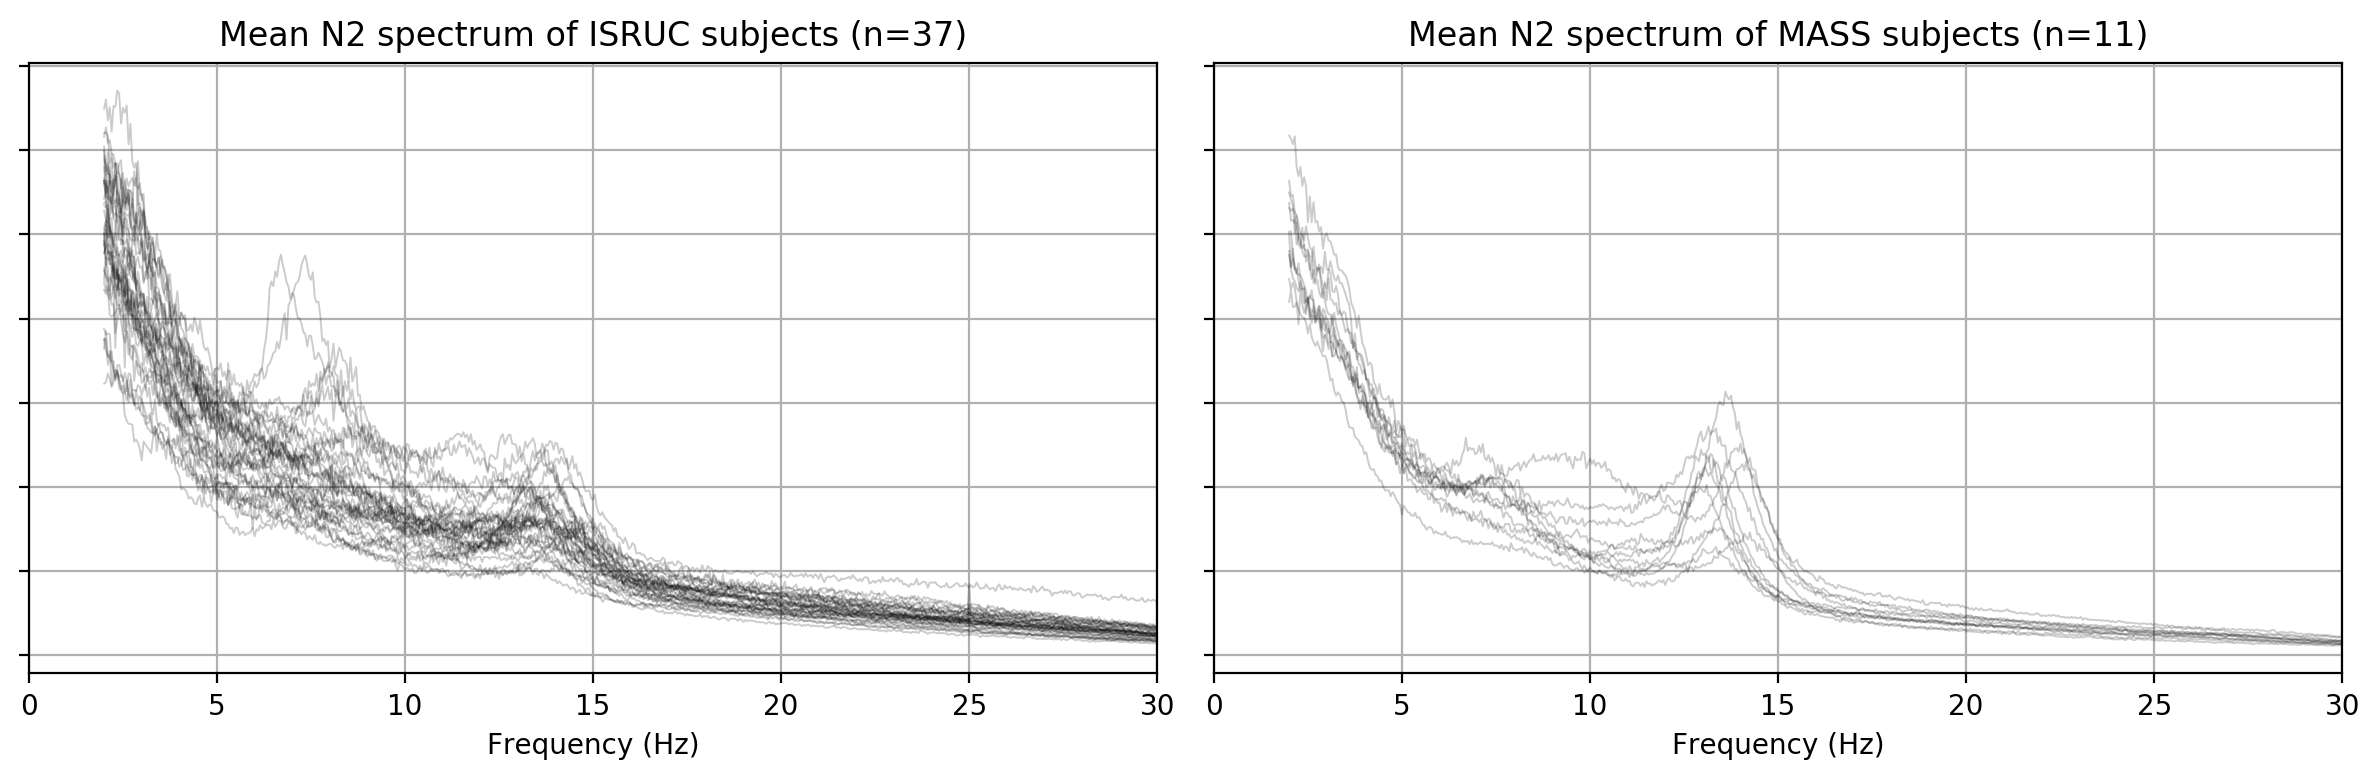

In [81]:
# side by side

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=200, sharey=True, sharex=True)
min_freq = 2
max_freq = 30
plot_indices = np.where((freq >= min_freq) & (freq <= max_freq))[0]

# isruc
ax = axes[0]
for subject_id in mean_power_dict.keys():
    ax.plot(freq[plot_indices], mean_power_dict[subject_id][plot_indices], linewidth=0.7, color="k", alpha=0.2)
    ax.set_xlim([0, 30])
    # ax.set_yticks([])
    ax.set_yticklabels([])
ax.set_title("Mean N2 spectrum of ISRUC subjects (n=%d)" % len(mean_power_dict.keys()))
ax.set_xlabel("Frequency (Hz)")
ax.grid()

# mass
ax = axes[1]
for subject_id in mass_mean_power_dict.keys():
    ax.plot(freq[plot_indices], mass_mean_power_dict[subject_id][plot_indices], linewidth=0.7, color="k", alpha=0.2)
    ax.set_xlim([0, 30])
    # ax.set_yticks([])
ax.set_title("Mean N2 spectrum of MASS subjects (n=%d)" % len(mass_mean_power_dict.keys()))
ax.set_xlabel("Frequency (Hz)")
ax.grid()

plt.tight_layout()
plt.show()

# Save ISRUC *.mat files

In [65]:
import scipy.io

In [71]:
os.makedirs("isruc_subset_mat", exist_ok=True)
for subject_id in subject_ids:
    this_signal = signal_dict[subject_id]
    this_signal = this_signal * mass.global_std
    this_n2_pages_from_zero = n2_pages_dict[subject_id]
    fname = os.path.join("isruc_subset_mat", "isruc_s%s_fs_%s.mat" % (subject_id, fs))
    print(this_signal.min(), this_signal.max())
    scipy.io.savemat(fname, {"signal": this_signal, "n2_pages_from_zero": this_n2_pages_from_zero})

-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
-164.82042 164.82042
